# data_selection_and_cleaning

This notebook deals with selecting features to use for estimating the NOx emissions, and visualising them / cleaning them if necessary.

In [29]:
### set path to include custom functions
import sys
sys.path.insert(0, '../PythonScripts/')

### libraries

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# data manipulation
import pandas as pd
import numpy as np

# stats
from scipy.stats import kurtosis, skew

# custom functions
from preprocessing import scale_data


In [3]:
path = '../data/Boston_Housing_Market_Challenge/boston_corrected.csv'

df = pd.read_csv(path)

df.head()

,TOWN,TOWNNO,TRACT,LON,LAT,MEDV,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,Nahant,0,2011,-70.955,42.2550,24.0,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,Swampscott,1,2021,-70.950,42.2875,21.6,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,Swampscott,1,2022,-70.936,42.2830,34.7,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,Marblehead,2,2031,-70.928,42.2930,33.4,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,Marblehead,2,2032,-70.922,42.2980,36.2,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [49]:
df.TOWN.values

array(['Nahant', 'Swampscott', 'Swampscott', 'Marblehead', 'Marblehead',
       'Marblehead', 'Salem', 'Salem', 'Salem', 'Salem', 'Salem', 'Salem',
       'Salem', 'Lynn', 'Lynn', 'Lynn', 'Lynn', 'Lynn', 'Lynn', 'Lynn',
       'Lynn', 'Lynn', 'Lynn', 'Lynn', 'Lynn', 'Lynn', 'Lynn', 'Lynn',
       'Lynn', 'Lynn', 'Lynn', 'Lynn', 'Lynn', 'Lynn', 'Lynn', 'Sargus',
       'Sargus', 'Sargus', 'Sargus', 'Lynnfield', 'Lynnfield', 'Peabody',
       'Peabody', 'Peabody', 'Peabody', 'Peabody', 'Peabody', 'Peabody',
       'Peabody', 'Peabody', 'Danvers', 'Danvers', 'Danvers', 'Danvers',
       'Middleton', 'Topsfield', 'Hamilton', 'Wenham', 'Beverly',
       'Beverly', 'Beverly', 'Beverly', 'Beverly', 'Beverly',
       'Manchester', 'North Reading', 'North Reading', 'Wilmington',
       'Wilmington', 'Wilmington', 'Burlington', 'Burlington',
       'Burlington', 'Burlington', 'Woburn', 'Woburn', 'Woburn', 'Woburn',
       'Woburn', 'Woburn', 'Reading', 'Reading', 'Reading', 'Reading',
       'Wa

<AxesSubplot:ylabel='TRACT'>

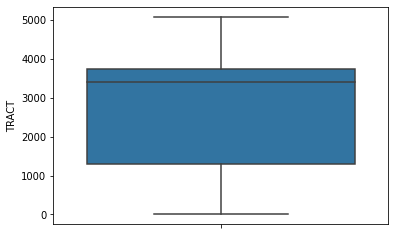

In [6]:
sns.boxplot(y = 'TRACT', data = df)

<AxesSubplot:ylabel='TAX'>

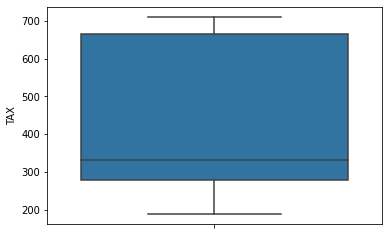

In [8]:
sns.boxplot(y = 'TAX', data = df)

In [18]:
columns = list(df.columns)
columns.remove('TRACT')
columns.remove('TAX')

['TOWN',
 'TOWNNO',
 'LON',
 'LAT',
 'MEDV',
 'CMEDV',
 'CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'PTRATIO',
 'B',
 'LSTAT']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'TOWNNO'),
  Text(1, 0, 'LON'),
  Text(2, 0, 'LAT'),
  Text(3, 0, 'MEDV'),
  Text(4, 0, 'CMEDV'),
  Text(5, 0, 'CRIM'),
  Text(6, 0, 'ZN'),
  Text(7, 0, 'INDUS'),
  Text(8, 0, 'CHAS'),
  Text(9, 0, 'NOX'),
  Text(10, 0, 'RM'),
  Text(11, 0, 'AGE'),
  Text(12, 0, 'DIS'),
  Text(13, 0, 'RAD'),
  Text(14, 0, 'PTRATIO'),
  Text(15, 0, 'B'),
  Text(16, 0, 'LSTAT')])

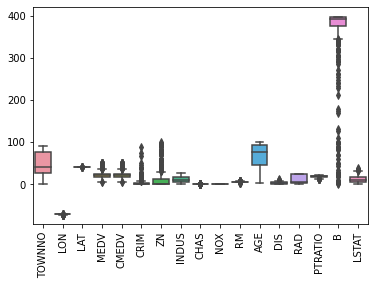

In [21]:
sns.boxplot(data = df[columns])
plt.xticks(rotation = 90)

Comments: there are many outliers on the data when it is not scaled. Scaling parameters need to be added. But before scaling, some de-skewers will be applied.

In [40]:
kurts = []
skews = []
for col in df.columns:
    if df[col].dtype != 'object':
        values = np.asarray(df[col])
        if (kurt:= kurtosis(values)) > 1:
            print(col, kurt)
        kurts.append(kurtosis(values))
        skews.append(skew(values))


LON 1.0857233436592795
MEDV 1.4686287722747462
CMEDV 1.4900025601607387
CRIM 36.75278626142281
ZN 3.9799487739913717
CHAS 9.531452835911432
RM 1.8610269725310244
B 7.143769291496051


In [46]:
list(df.TOWN.value_counts())

[30,
 23,
 22,
 19,
 18,
 15,
 13,
 12,
 12,
 12,
 11,
 11,
 11,
 10,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

{'error_message': 'You must use an API key to authenticate each request to Google Maps Platform APIs. For additional information, please refer to http://g.co/dev/maps-no-account', 'results': [], 'status': 'REQUEST_DENIED'}


IndexError: list index out of range

# Conclusions and Thoughts

Age: seems to be a value that we'd be interested in? Older houses may have wood fired chimneys --> more NOx

LON/LAT or TOWN: this gives information about how close parameters are. They might also provide noise to the dataset though. Leaning towards LON/LAT since they are already continuous!

CMEDV: house pirce

DIS: distance from employment centres